# 1) Motion Estimation

In this problem you will implement the most critical part of the video codec – the motion estimator. Do the following:

Divide each frame into non-overlapping macroblocks of size 16×16 pixels. 
Note that the images are of size
176 × 144.
• Generate motion vectors at each macroblock in the second frame from the first.

1. Use the 3-step search to find motion vectors (check slides for description)

Use mean absolute distance (MAD) as your metric.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline
# to render images in gray 
plt.gray()

<Figure size 432x288 with 0 Axes>

In [2]:
# two frames of video
first_frame = mpimg.imread('first_frame.png')
second_frame = mpimg.imread('second_frame.png')

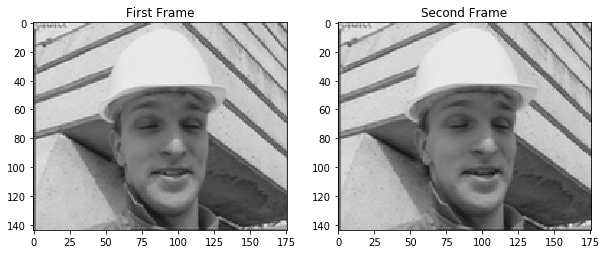

In [3]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('First Frame')
ax.imshow(first_frame)
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Second Frame')
ax.imshow(second_frame)

In [4]:
print(first_frame.shape, second_frame.shape)

(144, 176) (144, 176)


In [5]:
block_size = (16, 16)

In [6]:
first_frame.shape

(144, 176)

In [7]:
image_size = (144, 176)

In [8]:
n_blocks = int((image_size[0]*image_size[1])/(block_size[0]*block_size[1]))
print(n_blocks)

99


In [9]:
# blocks_loc is coordinates of center of all 16*16 macro blocks in image
# blocks_loc is populated from left to right and then top to bottom manner
blocks_loc = []
n_blocks_x = image_size[1]//block_size[1]
n_blocks_y = image_size[0]//block_size[0]
for y in range(n_blocks_y):
    for x in range(n_blocks_x):
        x_coord = x*block_size[1]+block_size[1]//2
        y_coord = y*block_size[0]+block_size[0]//2
        blocks_loc.append([x_coord, y_coord])

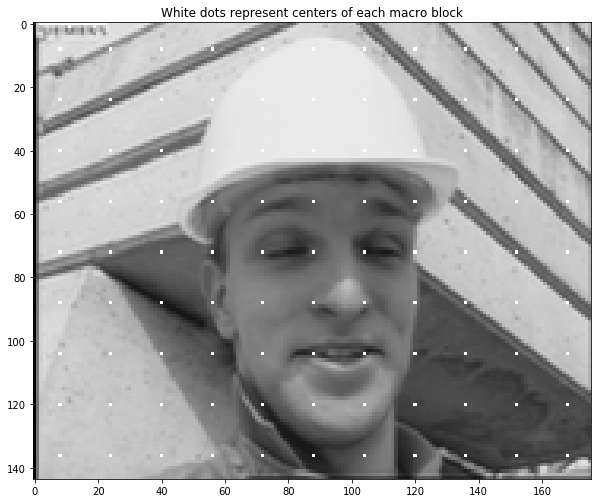

In [10]:
temp = np.copy(first_frame)
for block in blocks_loc:
    x=block[0]
    y=block[1]
    temp[y][x]=1
fig = plt.figure(figsize=(10,10))
plt.title('White dots represent centers of each macro block')
plt.imshow(temp)

In [11]:
# mean absolute difference metric for calculating difference between two images
# x1, y1 and x2, y2 are coordinates of centers of blocks 
def mean_absolute_distance(image_1, x1, y1, image_2, x2, y2):
    width, height = block_size[1]//2, block_size[0]//2
    # calculating difference of blocks centered at x1,y1 and x2,y2
    total_diff = np.sum(np.absolute(image_1[y1-height:y1+height, x1-width:x1+width]-image_2[y2-height:y2+height, x2-width:x2+width]))
    mad = total_diff/(block_size[0]*block_size[1])
    return mad

Step 1: Search at 8 location ± 4 pixels around current macroblock including (0, 0) (relative to current
macroblock).

In [12]:
# check if all the points of block are inside image
def in_range(center_x, center_y):
    # leftmost x coordinate
    left_x = center_x - block_size[1]//2
    # rightmost x coordinate
    right_x = center_x + block_size[1]//2 - 1
    # top y coordinate
    top_y = center_y - block_size[0]//2
    # bottom y coordinate
    bottom_y = center_y + block_size[0]//2 - 1
    # checking if block centered at center_x and center_y is inside image
    if left_x < 0 or right_x >= image_size[1] or top_y < 0 or bottom_y >= image_size[0]:
        return False
    return True

In [13]:
# find coordinates of points at given distance in all 9 directions around given point
def find_centers(x, y, distance):
    dx = [-1, 0, 1, -1, 0, 1, -1, 0, 1]
    dy = [-1, -1, -1, 0, 0, 0, 1, 1, 1]
    centers = []
    for idx in range(len(dx)):
        center_x = x + distance*dx[idx]
        center_y = y + distance*dy[idx]
        # checking if block centered at center_x and center_y lies inside image or not
        if in_range(center_x, center_y):
            centers.append([center_x, center_y])
    return centers

In [14]:
# first search, finds closest match with points at a distance of (-4,-4) to (+4,+4) from given point
def first_search(image_1, image_2, x, y):
    nearest_centers = find_centers(x, y, 4)
    min_mad = float('inf')
    min_mad_center = (x, y)
    # min_mad_center is center of block which has minimum MAD with block centered at x,y
    for center in nearest_centers:
        mad = mean_absolute_distance(image_1, x, y, image_2, center[0], center[1])
        if mad < min_mad:
            min_mad = mad
            min_mad_center = center
    return min_mad_center

In [15]:
first_search_centers_loc = []
for block_loc in blocks_loc:
    center = first_search(first_frame, second_frame, block_loc[0], block_loc[1])
    first_search_centers_loc.append(center)

In [16]:
#  print(first_search_centers_loc)

In [17]:
print(len(first_search_centers_loc))

99


Step 2: search at 8 location ± 2 pixels around best match location in Step 1 including best match location.

In [18]:
# second search, finds closest match with points at a distance of (-2,-2) to (+2,+2) from given point
def second_search(image_1, image_2, x, y):
    nearest_centers = find_centers(x, y, 2)
    min_mad = float('inf')
    min_mad_center = (x, y)
    # min_mad_center is center of block which has minimum MAD with block centered at x,y
    for center in nearest_centers:
        mad = mean_absolute_distance(image_1, x, y, image_2, center[0], center[1])
        if mad < min_mad:
            min_mad = mad
            min_mad_center = center
    return min_mad_center

In [19]:
second_search_centers_loc = []
# for second search, using best block obtained from first search
for block_loc in first_search_centers_loc:
    center = second_search(first_frame, second_frame, block_loc[0], block_loc[1])
    second_search_centers_loc.append(center)

In [20]:
# print(second_search_centers_loc)

In [21]:
print(len(second_search_centers_loc))

99


Step 3: search at 8 location ± 1 pixels around best match location in Step 2 including best match location.

In [22]:
# third search, finds closest match with points at a distance of (-1,-1) to (+1,+1) from given point
def third_search(image_1, image_2, x, y):
    nearest_centers = find_centers(x, y, 1)
    min_mad = float('inf')
    min_mad_center = (x, y)
    # min_mad_center is center of block which has minimum MAD with block centered at x,y
    for center in nearest_centers:
        mad = mean_absolute_distance(image_1, x, y, image_2, center[0], center[1])
        if mad < min_mad:
            min_mad = mad
            min_mad_center = center
    return min_mad_center

In [23]:
third_search_centers_loc = []
# for third search, using best block obtained from second search
for block_loc in second_search_centers_loc:
    center = third_search(first_frame, second_frame, block_loc[0], block_loc[1])
    third_search_centers_loc.append(center)

In [24]:
# print(third_search_centers_loc)

In [25]:
print(len(third_search_centers_loc))

99


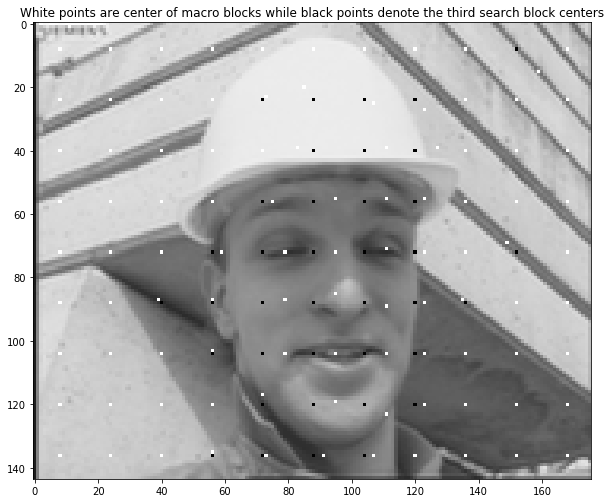

In [26]:
temp = np.copy(first_frame)
for block in blocks_loc:
    x=block[0]
    y=block[1]
    temp[y][x]=0
for block in third_search_centers_loc:
    x=block[0]
    y=block[1]
    temp[y][x]=1
fig = plt.figure(figsize=(10,10))
plt.title('White points are center of macro blocks while black points denote the third search block centers')
plt.imshow(temp)

2. Plot the motion vector at each macroblock. You can use the arrow function in matplotlib.

In [27]:
def get_motion_vector(x1, y1, x2, y2):
    return (x2 - x1, y2 - y1)

In [28]:
# motion vectors for each macro block
motion_vectors = []
for idx in range(len(blocks_loc)):
    # motion vector first coordinate denotes final minus initial x coordinate of block centers
    # motion vector second coordinate denotes final minus initial y coordinate of block centers
    # i.e. third_search block centers - original block centers
    motion_vector = get_motion_vector(blocks_loc[idx][0], blocks_loc[idx][1], third_search_centers_loc[idx][0], third_search_centers_loc[idx][1])
    motion_vectors.append(motion_vector)

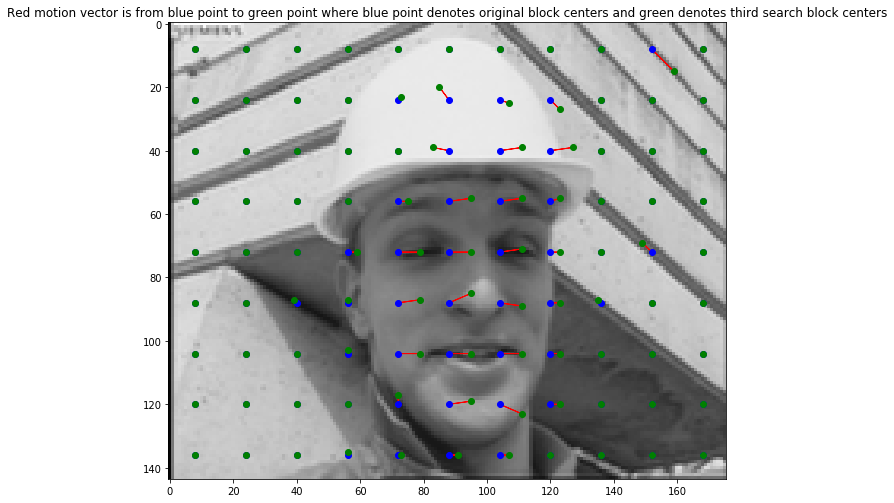

In [29]:
fig = plt.figure(figsize=(10,10))
plt.title('Red motion vector is from blue point to green point where blue point denotes original block centers and green denotes third search block centers')
plt.imshow(first_frame)
for block in blocks_loc:
    x=block[0]
    y=block[1]
    plt.plot(x, y, color='blue', marker='o')
for block in third_search_centers_loc:
    x=block[0]
    y=block[1]
    plt.plot(x, y, color='green', marker='o')
# plt.arrow(10,0,10,10)
for idx in range(len(blocks_loc)):
    plt.arrow(blocks_loc[idx][0], blocks_loc[idx][1], motion_vectors[idx][0], motion_vectors[idx][1], color='red')

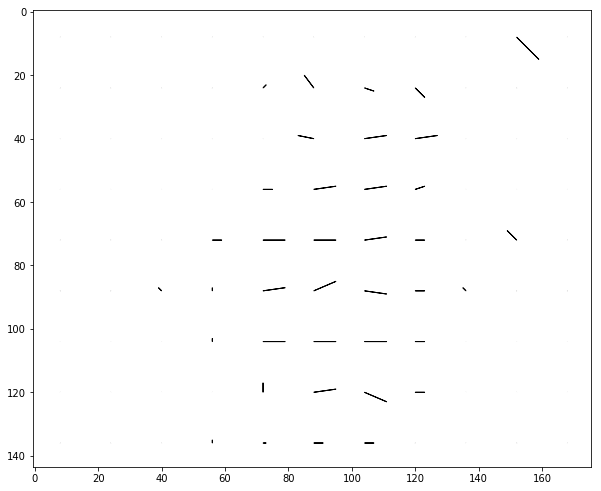

In [30]:
fig = plt.figure(figsize=(10,10))
temp = np.ones((image_size[0],image_size[1]))
plt.imshow(temp, vmin=0, vmax=1)
for idx in range(len(blocks_loc)):
    plt.arrow(blocks_loc[idx][0], blocks_loc[idx][1], motion_vectors[idx][0], motion_vectors[idx][1])

3. Generate the motion compensated predicted frame using the motion vectors and the first frame.

In [31]:
# Generate motion compensated predicted frame from first frame and motion vectors
def generate_motion_compensated_predicted_frame(image, motion_vectors, blocks_loc):
    height, width = image.shape[0], image.shape[1]
    generated_image = np.copy(image)
    # looping through each macro block
    for idx in range(len(blocks_loc)):
        # current block
        x = blocks_loc[idx][0]
        y = blocks_loc[idx][1] 
        # motion vector for current block
        motion_vector_x = motion_vectors[idx][0]
        motion_vector_y = motion_vectors[idx][1]
        # calculating next x and next y coordinates using original block centers and motion vectors
        next_y = y + motion_vector_y
        next_x = x + motion_vector_x
        # loop through each coordinate of macro block with x and y as block center
        for i in range(-8, 8):
            for j in range(-8, 8):
                # checking if coordinates are inside bounds of image size or not
                if next_y+j < 0 or next_y+j >= height or next_x+i < 0 or next_x + i >= width:
                    continue
                # replacing block centered at (next_x, next_y) with current block
                # since motion compensated frame would have current block moved to 
                # block centered with next_x and next_y
                generated_image[next_y+j][next_x+i] = image[y+j][x+i]
    return generated_image

In [32]:
# Generate motion compensated predicted frame from first frame and motion vectors
# here replacing each block of motion compensated image with best block 
# from frame 1 by subtracing motion vector from block centers
def generate_motion_compensated_predicted_frame_1(image, motion_vectors, blocks_loc):
    height, width = image.shape[0], image.shape[1]
    generated_image = np.zeros((height, width))
    # looping through each macro block
    for idx in range(len(blocks_loc)):
        # current block
        x = blocks_loc[idx][0]
        y = blocks_loc[idx][1] 
        # motion vector for current block
        motion_vector_x = motion_vectors[idx][0]
        motion_vector_y = motion_vectors[idx][1]
        # calculating next x and next y coordinates using original block centers and motion vectors
        next_y = y - motion_vector_y
        next_x = x - motion_vector_x
        # loop through each coordinate of macro block with x and y as block center
        for i in range(-8, 8):
            for j in range(-8, 8):
                # checking if coordinates are inside bounds of image size or not
                if next_y+j < 0 or next_y+j >= height or next_x+i < 0 or next_x + i >= width:
                    continue
                # replacing block centered at (next_x, next_y) with current block
                # since motion compensated frame would have current block moved to 
                # block centered with next_x and next_y
                generated_image[y+j][x+i] = image[next_y+j][next_x+i]
    return generated_image

In [33]:
generated_image = generate_motion_compensated_predicted_frame(first_frame, motion_vectors, blocks_loc)

In [34]:
generated_image_1 = generate_motion_compensated_predicted_frame_1(first_frame, motion_vectors, blocks_loc)

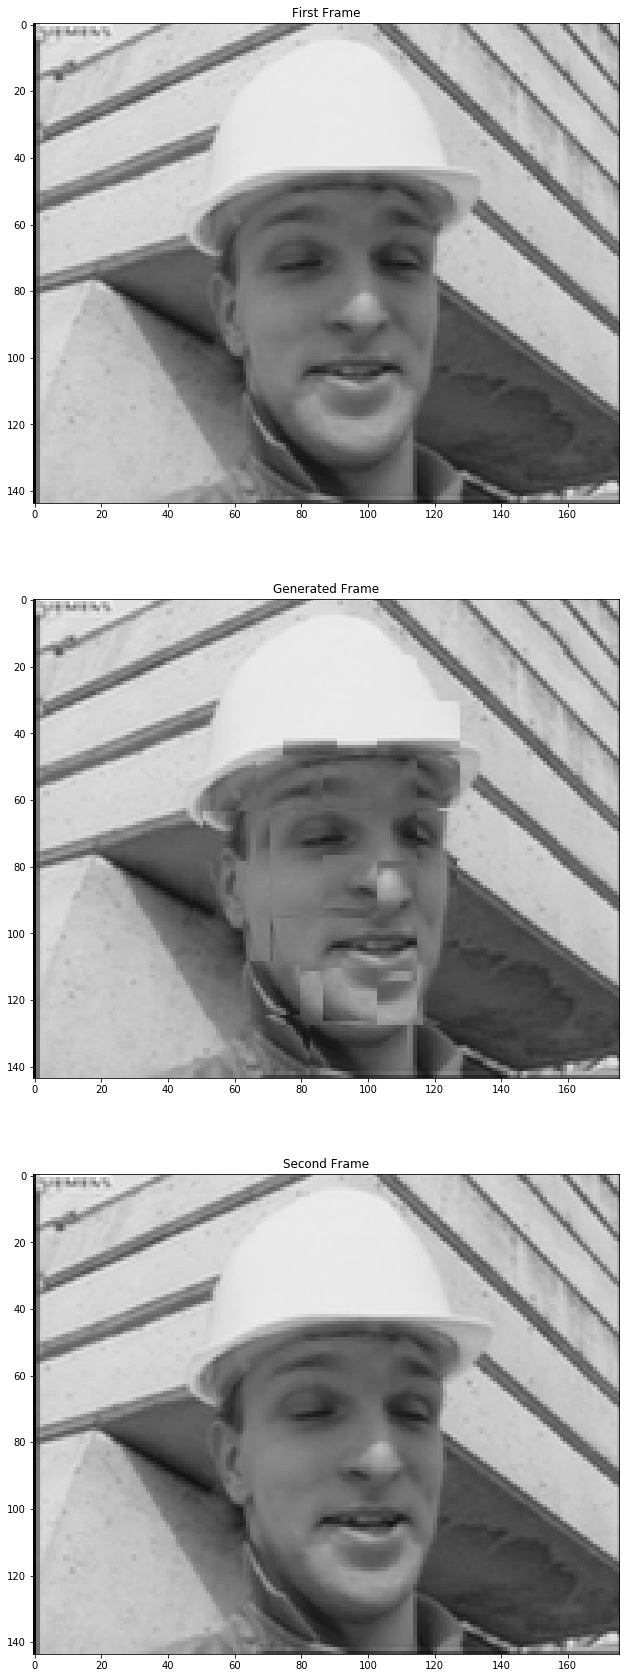

In [35]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(3, 1, 1)
ax.set_title('First Frame')
ax.imshow(first_frame)
ax = fig.add_subplot(3, 1, 2)
ax.set_title('Generated Frame')
ax.imshow(generated_image)
ax = fig.add_subplot(3, 1, 3)
ax.set_title('Second Frame')
ax.imshow(second_frame)

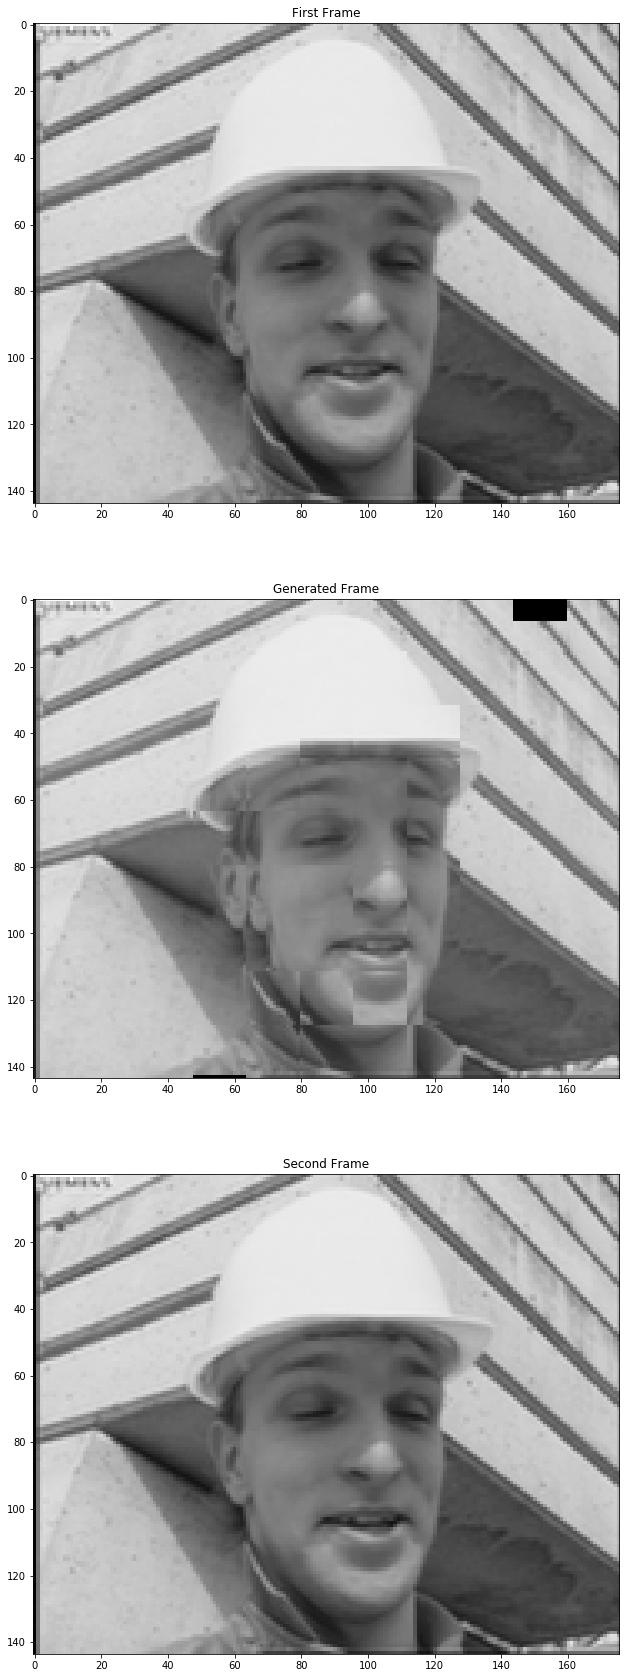

In [36]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(3, 1, 1)
ax.set_title('First Frame')
ax.imshow(first_frame)
ax = fig.add_subplot(3, 1, 2)
ax.set_title('Generated Frame')
ax.imshow(generated_image_1)
ax = fig.add_subplot(3, 1, 3)
ax.set_title('Second Frame')
ax.imshow(second_frame)

4. Compute the error between the second frame and its motion compensated predicted version and display it.

MAD of second frame and its motion compensated predicted version is 0.01834042024130773


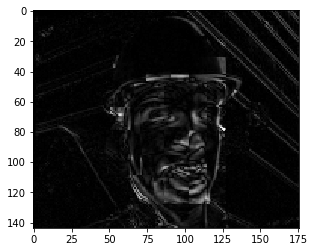

In [38]:
total_diff = np.absolute(generated_image-second_frame)
error = np.sum(total_diff)/(image_size[0]*image_size[1])
plt.imshow(total_diff)
print('MAD of second frame and its motion compensated predicted version is ' +str(error))

MAD of second frame and its motion compensated predicted version is 0.022518228185057377


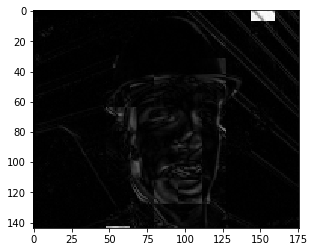

In [40]:
total_diff = np.absolute(generated_image_1-second_frame)
error = np.sum(total_diff)/(image_size[0]*image_size[1])
plt.imshow(total_diff)
print('MAD of second frame and its motion compensated predicted version is ' +str(error))

Performing above operations on frames after scaling pixel values to 255

In [41]:
first_frame = first_frame*255
second_frame = second_frame*255

In [42]:
print(np.max(first_frame))
print(np.max(second_frame))

255.0
255.0


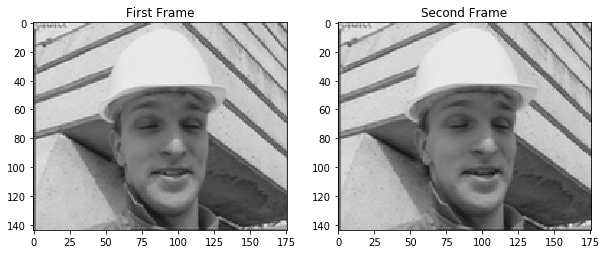

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('First Frame')
ax.imshow(first_frame)
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Second Frame')
ax.imshow(second_frame)

In [44]:
first_search_centers_loc = []
for block_loc in blocks_loc:
    center = first_search(first_frame, second_frame, block_loc[0], block_loc[1])
    first_search_centers_loc.append(center)

In [45]:
second_search_centers_loc = []
# for second search, using best block obtained from first search
for block_loc in first_search_centers_loc:
    center = second_search(first_frame, second_frame, block_loc[0], block_loc[1])
    second_search_centers_loc.append(center)

In [46]:
third_search_centers_loc = []
# for third search, using best block obtained from second search
for block_loc in second_search_centers_loc:
    center = third_search(first_frame, second_frame, block_loc[0], block_loc[1])
    third_search_centers_loc.append(center)

In [47]:
# motion vectors for each macro block
motion_vectors = []
for idx in range(len(blocks_loc)):
    # motion vector first coordinate denotes final minus initial x coordinate of block centers
    # motion vector second coordinate denotes final minus initial y coordinate of block centers
    # i.e. third_search block centers - original block centers
    motion_vector = get_motion_vector(blocks_loc[idx][0], blocks_loc[idx][1], third_search_centers_loc[idx][0], third_search_centers_loc[idx][1])
    motion_vectors.append(motion_vector)

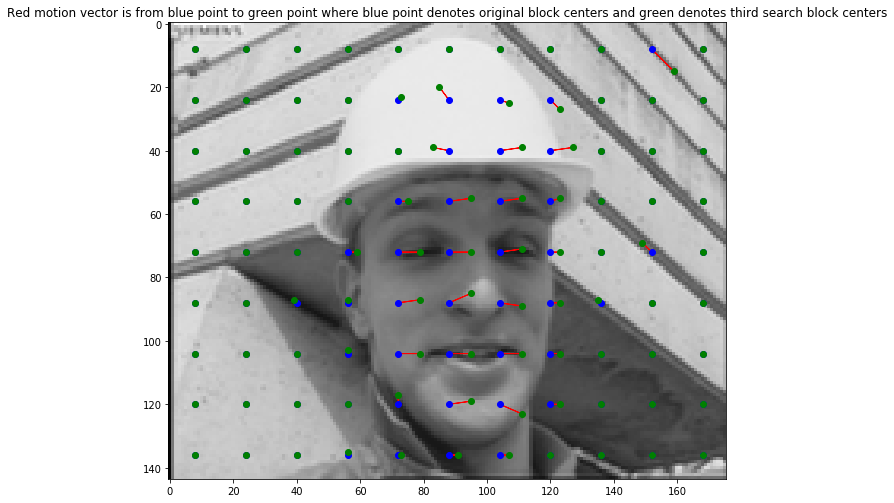

In [48]:
fig = plt.figure(figsize=(10,10))
plt.title('Red motion vector is from blue point to green point where blue point denotes original block centers and green denotes third search block centers')
plt.imshow(first_frame)
for block in blocks_loc:
    x=block[0]
    y=block[1]
    plt.plot(x, y, color='blue', marker='o')
for block in third_search_centers_loc:
    x=block[0]
    y=block[1]
    plt.plot(x, y, color='green', marker='o')
# plt.arrow(10,0,10,10)
for idx in range(len(blocks_loc)):
    plt.arrow(blocks_loc[idx][0], blocks_loc[idx][1], motion_vectors[idx][0], motion_vectors[idx][1], color='red')

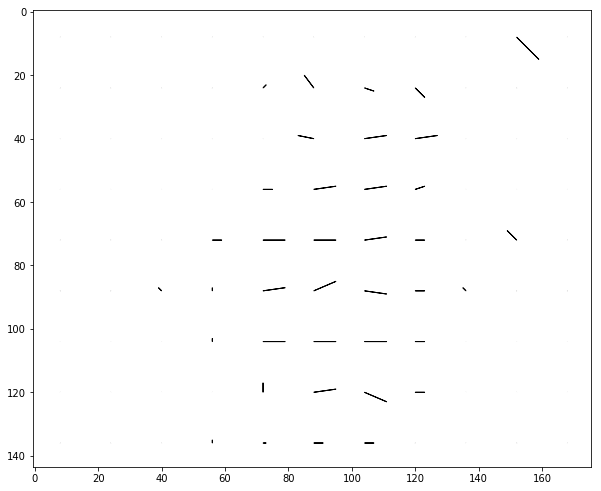

In [49]:
fig = plt.figure(figsize=(10,10))
temp = np.ones((image_size[0],image_size[1]))
plt.imshow(temp, vmin=0, vmax=1)
for idx in range(len(blocks_loc)):
    plt.arrow(blocks_loc[idx][0], blocks_loc[idx][1], motion_vectors[idx][0], motion_vectors[idx][1])

In [50]:
generated_image = generate_motion_compensated_predicted_frame(first_frame, motion_vectors, blocks_loc)

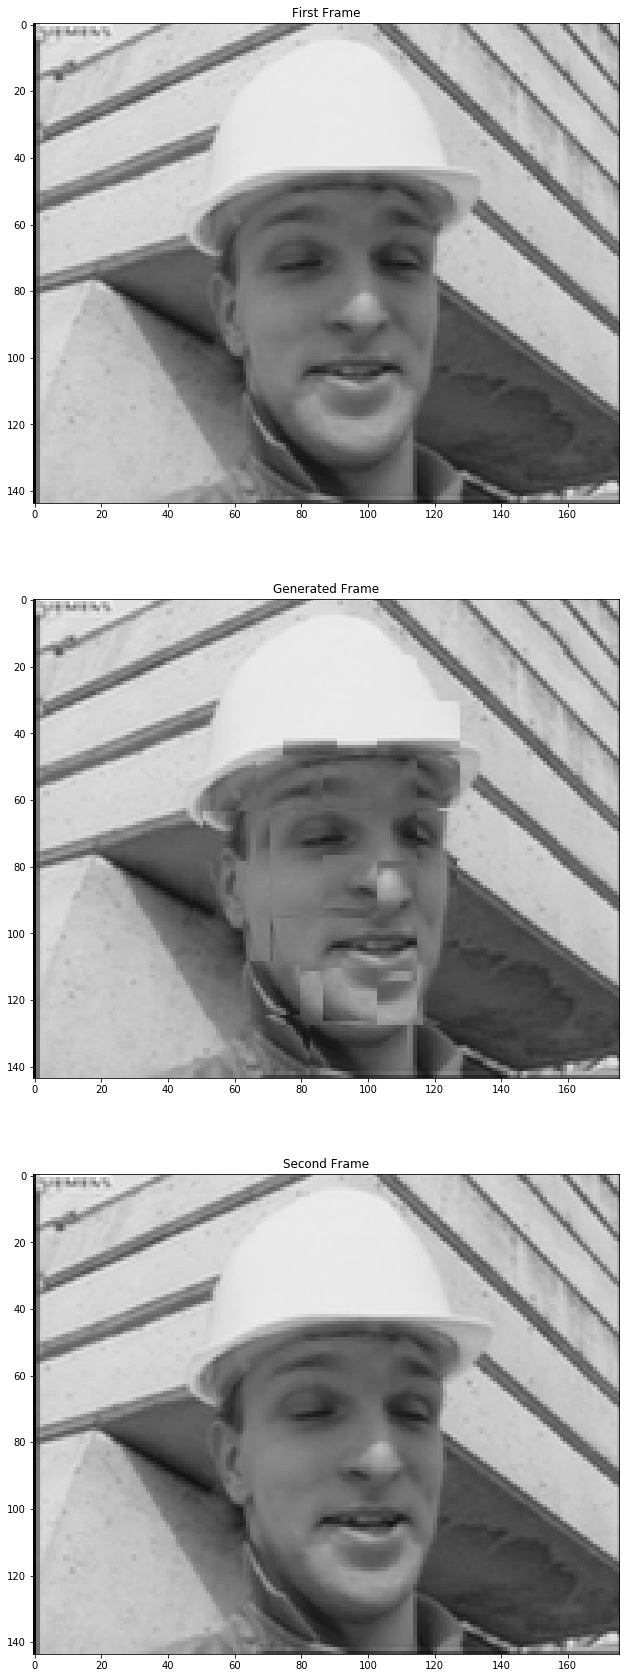

In [51]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(3, 1, 1)
ax.set_title('First Frame')
ax.imshow(first_frame)
ax = fig.add_subplot(3, 1, 2)
ax.set_title('Generated Frame')
ax.imshow(generated_image)
ax = fig.add_subplot(3, 1, 3)
ax.set_title('Second Frame')
ax.imshow(second_frame)

In [52]:
generated_image_1 = generate_motion_compensated_predicted_frame_1(first_frame, motion_vectors, blocks_loc)

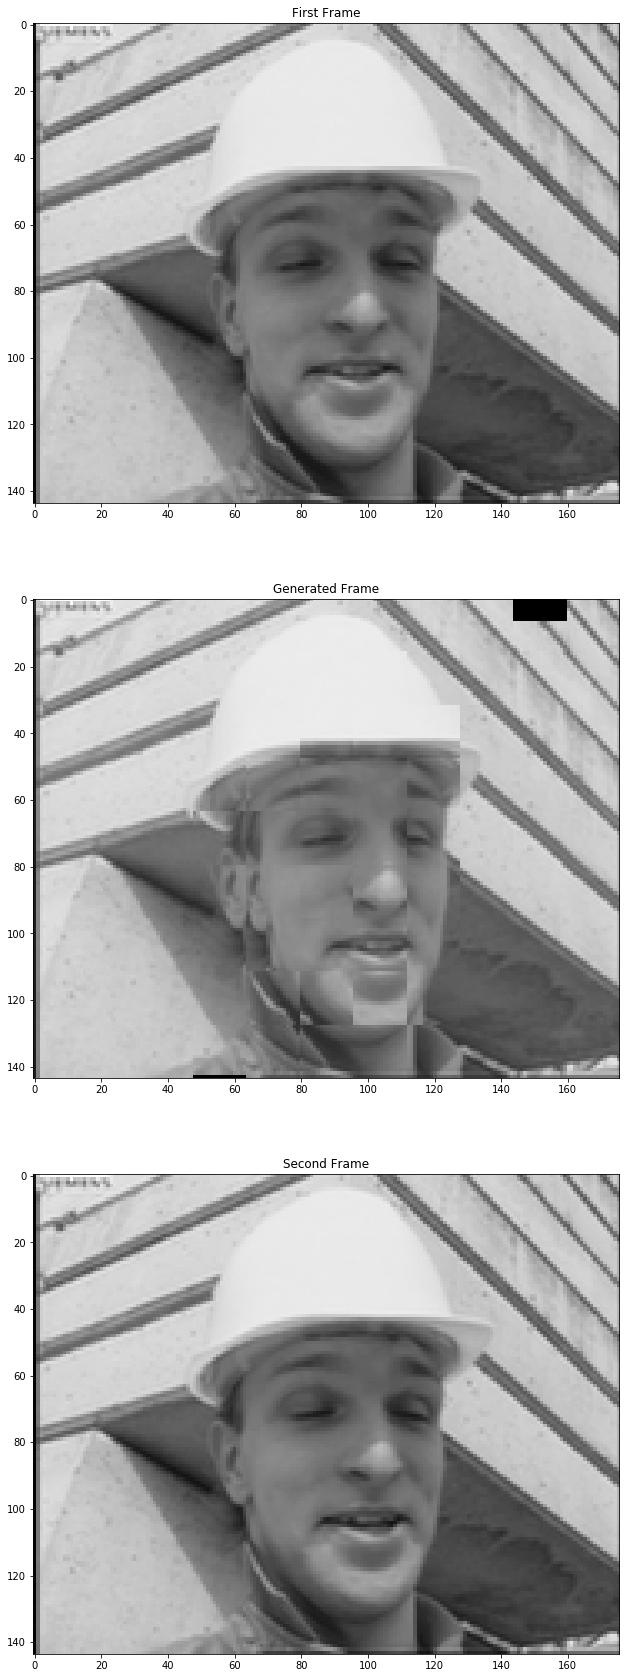

In [53]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(3, 1, 1)
ax.set_title('First Frame')
ax.imshow(first_frame)
ax = fig.add_subplot(3, 1, 2)
ax.set_title('Generated Frame')
ax.imshow(generated_image_1)
ax = fig.add_subplot(3, 1, 3)
ax.set_title('Second Frame')
ax.imshow(second_frame)

MAD of second frame and its motion compensated predicted version is 4.676807133838384


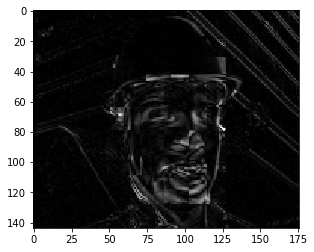

In [55]:
total_diff = np.absolute(generated_image-second_frame)
error = np.sum(total_diff)/(image_size[0]*image_size[1])
plt.imshow(total_diff)
print('MAD of second frame and its motion compensated predicted version is ' +str(error))

MAD of second frame and its motion compensated predicted version is 5.742148042929293


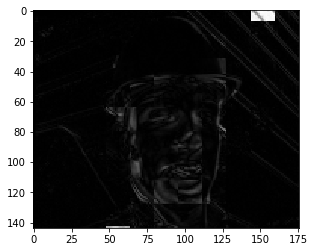

In [57]:
total_diff = np.absolute(generated_image_1-second_frame)
error = np.sum(total_diff)/(image_size[0]*image_size[1])
plt.imshow(total_diff)
print('MAD of second frame and its motion compensated predicted version is ' +str(error))